In [ ]:
!pip install -r requirements.txt

In [18]:
import dask.dataframe as dd
import string
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import datasets
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.feature_extraction.text import CountVectorizer
#import os.path
#import tensorflow as tf
#import tensorflow_text as text
#import heapq
from collections import defaultdict
import nltk
from nltk.corpus import stopwords

df = dd.read_parquet("hf://datasets/OpenCo7/UpVoteWeb/data/*.parquet")

nltk.download('stopwords')

data_path = '../local_data/'

/home/nskandera/myenv/lib/python3.9/site-packages/dask/dataframe/io/parquet/core.py:1247: FutureWarning: Could not find pyarrow; falling back to fastparquet, which is deprecated and will be removed in a future release.
  warnings.warn(
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/nskandera/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [19]:
df = df[df['language'] == 'en']
columns_to_drop = ['url', 'author', 'kind', 'language', 'language_score', 'media_urls', 'date']
df = df.drop(columns=columns_to_drop)

In [20]:
df['text'] = df['text'].str.lower()
df['text'] = df['text'].str.translate(str.maketrans('', '', string.punctuation))


In [21]:
shortdf = df.head(10000)


In [29]:
# Words list sourced online and added to
dropwords = ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 
'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 
'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 
'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves',
 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are',
 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing',
 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 
'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 
'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 
'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 
'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', 'too', 'very', 
's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', 've', 'y',
 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 
'hadn', "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn',
 "mightn't", 'mustn', "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 
'wasn', "wasn't", 'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't", 'dont', "it`s"]

for i, row in shortdf.iterrows():
    comment = row['text'].split()
    keepwords = [word for word in comment if word not in dropwords]
    row['text'] = ' '.join(keepwords)
    shortdf.loc[i, 'text'] = row['text']
    

In [8]:
shortdf.head(10)


,id,parent_id,post_id,text,subreddit,score,token_count
0,kfrxfcr,t3_18vki9b,18vki9b,devsisters generous guys generosity,CookieRunKingdoms,35,13
1,kfrxfdj,t3_18vlhgc,18vlhgc,omar epps waiting wings star movie tomlin retires,nfl,253,19
2,kfrxfde,t3_18vkkxu,18vkkxu,may 1899 better year us 1899 1899,fallenlondon,39,15
3,kfrxfda,t3_18vkqmn,18vkqmn,clean bit almost subway tiles matte finish dar...,Renovations,1,32
4,kfrxfdl,t1_kfrwiiz,18vl745,absolutely pleasant little guys disclaimer any...,PokeMedia,7,46
6,kfrxfco,t1_kfrhevt,18vhenj,throwreset mouse click much shorter controller...,ModernWarfareIII,1,60
7,kfrxfds,t1_kfrbnij,18vfi1t,yeah remember fair posts around release saying...,gaming,52,43
8,kfrxfed,t1_kfrh3zc,18v8sib,late shell standard pool patches youll waiting,Reverse1999,3,22
9,kfrxfeh,t3_18vihun,18vihun,freddy got fingered absurd top juvenile ridicu...,MovieSuggestions,6,35
10,kfrxfdu,t3_18shtxl,18shtxl,i’m sure she’s grease some…um…palms,politics,1,20


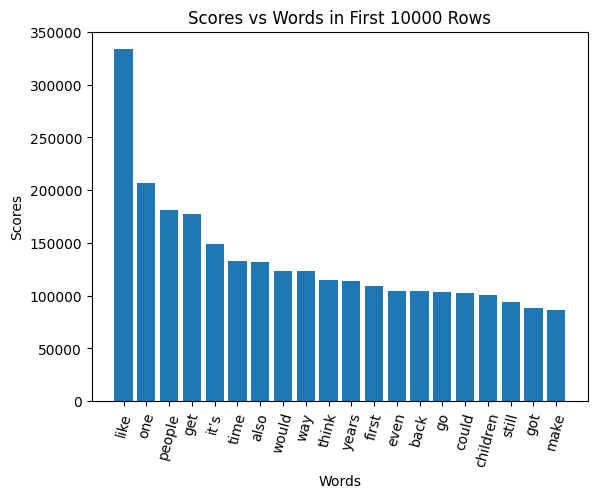

In [55]:
counts = defaultdict(int)

for i, j in shortdf.iterrows():
    score = j['score']
    comment = j['text'].split()
    for word in comment:
        word_scores[word] += score
        
# GPT: "how do you rank words based on values of another column in a dataframe"
# answer was completely modified
max_score = max(word_scores.values())

top_words = [word for (word, score) in word_scores.items() if score == max_score]
scores = pd.DataFrame(list(word_scores.items()), columns=['word', 'score'])

sorted_scores = scores.sort_values(by='score', ascending=False).head(20)

plt.bar(sorted_scores['word'], sorted_scores['score'])
plt.xlabel('Words')
plt.ylabel('Scores')
plt.xticks(rotation = 75)
plt.title('Scores vs Words in First 10000 Rows')
plt.show()